In [1]:
import numpy as np
import h5py
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import arviz as az
import ringdown as rd

from pyRing import pyRing
from pyRing import likelihood
from pyRing import noise

from tqdm import tqdm

/work/yifan.wang/more_ringdown/runs/ringdown-runs/env-numpyro/lib/python3.7/site-packages/pyRing/utils.py:15: UserWarning: surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.
  warnings.warn("surfinBH is not automatically installed due to possible conflicts. If you wish to use its functionalities, it needs to be installed separately.")


# Run Pyring

In [2]:
import sys,importlib
sys.path.append("/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/")
from pyring_par import *
import data
import wheel

In [5]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1014,
                'sampling-rate': 16384, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*16384),})
model = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)




##########################
# [Setting the start time #
##########################

Trigtime in H1             : 1126259462.423000

* Warning: To err on the conservative side, when fixing the start time, pyRing selects the discrete sample immediately after the start time requested. This implies that the actual start time used in the analysis can be larger than the one requested up to 0.000061 s, i.e. 1/(sampling_rate). If you wish to reduce this error, please increase the sampling rate and the bandpassing frequency accordingly.



################
# [Data reading #
################


------
- [H1 -
------


* Using GWPY to download data.

Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

* Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.

* Bandpassing the raw strain between [20, 1014] Hz.

* Computing the one-sided PSD with the Welch method and the standard ACF for comparison.

* No ACF was passed. Estimating ACF.

* W

LinAlgError: Matrix is not positive definite

# Local load data

In [91]:
importlib.reload(data)
importlib.reload(wheel)

<module 'wheel' from '/work/yifan.wang/ringdown/GW150914/pyring/gitlab-ringdown-systematics/utils/wheel.py'>

In [80]:
pr_data  = {}
pr_time  = {}
for d in model.detectors.keys():
    pr_data[d],pr_time[d] = data.local_load_data(d,**test_par)


Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8

Reading data...

Using GWPY to download data.
Fetched 1 URLs from www.gw-openscience.org for [1126257414 .. 1126261510))
Reading data... [Done]

Loaded channel GWOSC starting at 1126257414.0 length 4096.0s.
Bandpassing the raw strain between [20, 1024] Hz.
Downsampling detector data from 16384.0 to 2048 Hz, decimate factor 8


# Plot data and waveform template in the same figure

In [83]:
%matplotlib inline
fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'legend.frameon': True,
          'legend.loc': 'best',
          'lines.markersize' : 14,
          'figure.figsize': fig_size}
mpl.rcParams.update(params)

In [84]:
rd_data = {}
for d in ['H1','L1']:
    rd_data[d] = fit.data[d]
    rd_data[d] = rd_data[d][(rd_data[d].index >= model.detectors['H1'].time[0]) \
                            & (rd_data[d].index <= model.detectors['H1'].time[-1])]

In [96]:
rdmfsnr = fit.compute_posterior_snrs(optimal=False)
i = np.argmax(rdmfsnr)
prefactor = np.sqrt(16*np.pi/5)
pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}

#This step is for computing waveform, PyRing doesn't output a waveform
result = wheel.wheel(model)

In [97]:
pyring_par

{'Mf': array(72.84400244),
 'af': array(0.72848178),
 'A2220': 5.595449455544791,
 'A2221': 6.457081321435618,
 'phi2220': -0.9737754582321143,
 'phi2221': 1.652119726595113}

In [98]:
wf_time, wf = result.get_hstrain(pyring_par,pr_time)

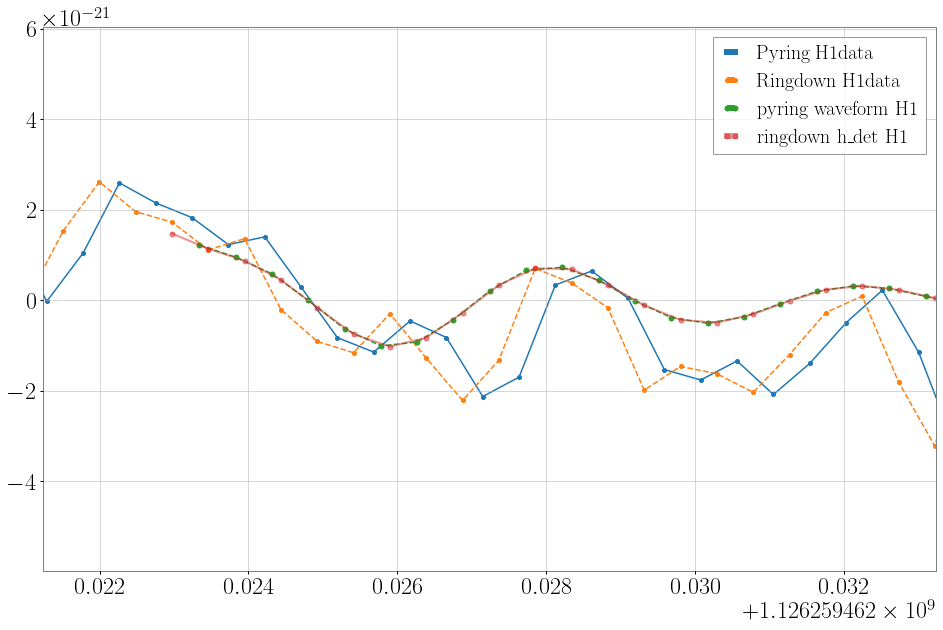

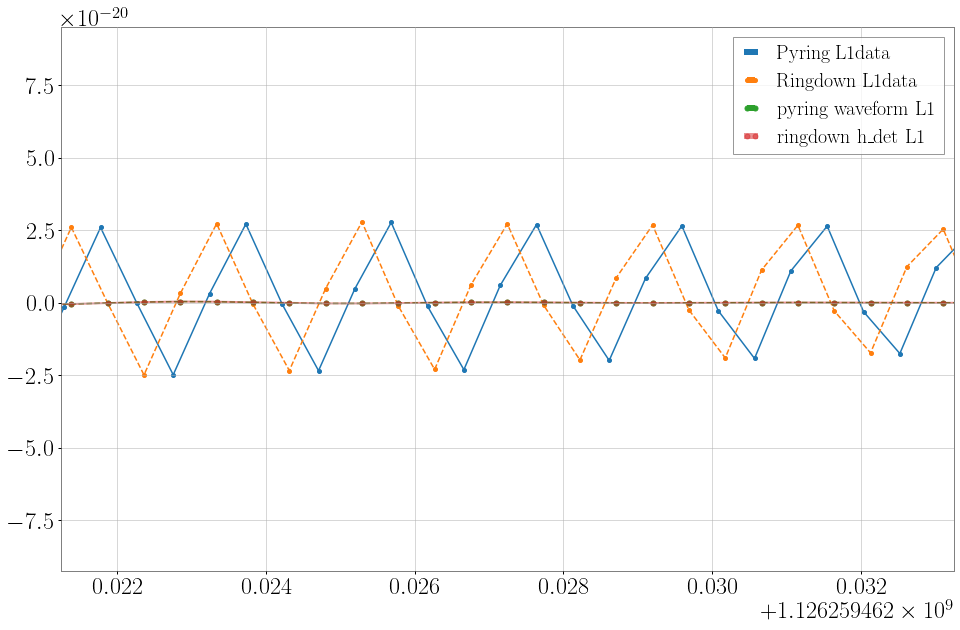

In [100]:
wf_time_array,dt = data.pyring_time(model)

#wf_time_array is the model.detector.time - model.tevent and cut to > 0.
for d in model.detectors.keys():
    plt.figure(figsize=[16,10])
    
    #plot data
    plt.plot(model.detectors[d].time,pr_data[d],marker='o',ms=4,label='Pyring '+str(d)+'data')
    plt.plot(rd_data[d].index,rd_data[d],ls='--',marker='o',ms=4,label='Ringdown '+str(d)+'data')

    #plot waveform   
    plt.plot(model.tevent+wf_time_array[d]+dt[d],result.get_hstrain(pyring_par)[d],
             ls='--',marker='o',ms=5,label='pyring waveform '+str(d))
    if d == 'H1':
        hsi=0
    else:
        hsi=1
    plt.plot(fit.analysis_data[d].index,hs[hsi,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det '+str(d))
    
    middle = model.detectors[d].time[len(model.detectors[d].time)//2]
    plt.xlim(middle-0.002,middle+0.01)
    plt.legend()

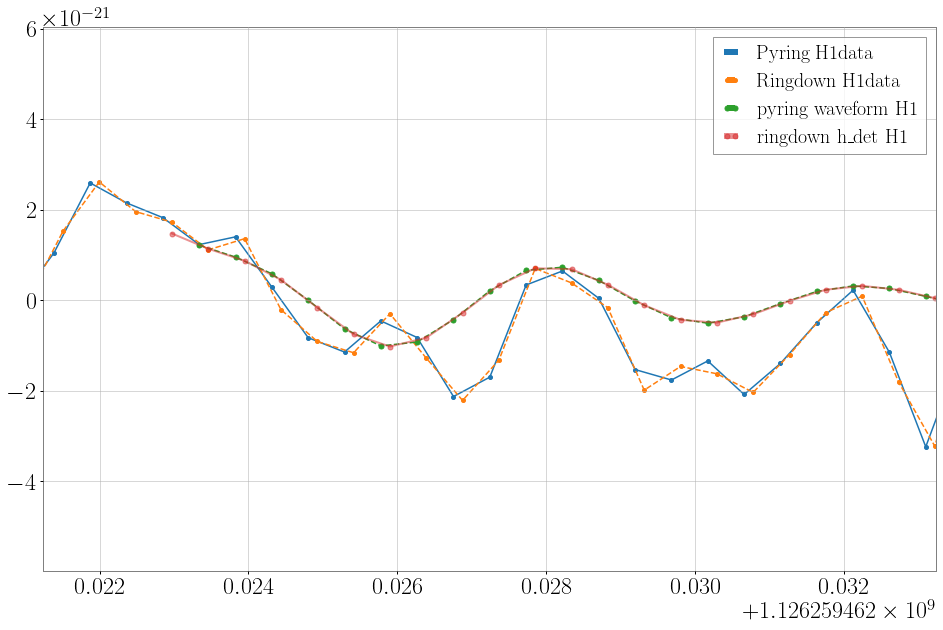

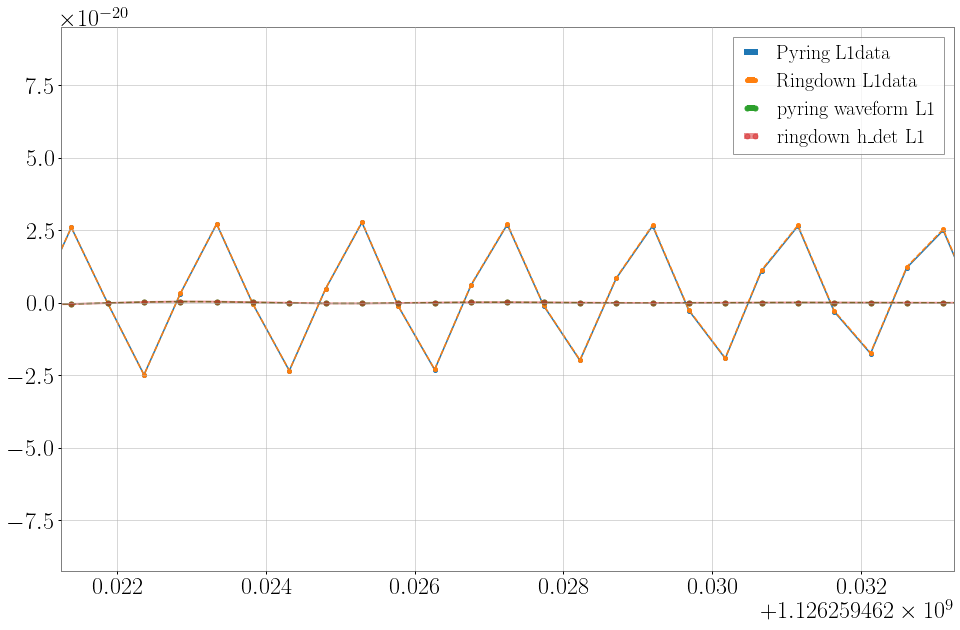

In [102]:
for d in model.detectors.keys():
    plt.figure(figsize=[16,10])
    
    #plot data
    plt.plot(pr_time[d],pr_data[d],marker='o',ms=4,label='Pyring '+str(d)+'data')
    plt.plot(rd_data[d].index,rd_data[d],ls='--',marker='o',ms=4,label='Ringdown '+str(d)+'data')

    #plot waveform   
    plt.plot(wf_time[d],wf[d],
             ls='--',marker='o',ms=5,label='pyring waveform '+str(d))
    if d == 'H1':
        hsi=0
    else:
        hsi=1
    plt.plot(fit.analysis_data[d].index,hs[hsi,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det '+str(d))
    
    middle = model.detectors[d].time[len(model.detectors[d].time)//2]
    plt.xlim(middle-0.002,middle+0.01)
    plt.legend()

In [17]:
np.sqrt(2 * (model.log_likelihood(pyring_par) - model.logZnoise))

12.522362315152748

# Plot the SNR series

In [ ]:
prmf = prmodel.mfsnr(pyring_par,network=False)
propt = prmodel.optsnr(pyring_par,network=False)

In [ ]:
pr_optsnr_net,pr_mfsnr_net = pyring_wheel.compute_pyring_snr(
    model,M,chi,A,phi,network=True,acf_from_psd=False)

In [ ]:
pr_optsnr_netafp,pr_mfsnr_netafp = pyring_wheel.compute_pyring_snr(
    model,M,chi,A,phi,network=True,acf_from_psd=True)

In [ ]:
pr_optsnr_netafr,pr_mfsnr_netafr = pyring_wheel.compute_pyring_snr(
    model,M,chi,A,phi,fit,network=True,acf_from_psd=False,acf_from_ringdown=True)

In [ ]:
pr_optsnr_nonet, pr_mfsnr_nonet = pyring_wheel.compute_pyring_snr(
    model,M,chi,A,phi,network=False)

In [ ]:
rd_optsnr = fit.compute_posterior_snrs(optimal=True,network=True)
rd_mfsnr = fit.compute_posterior_snrs(optimal=False,network=True)
rd_optsnr_nonet = fit.compute_posterior_snrs(optimal=True,network=False)
rd_mfsnr_nonet = fit.compute_posterior_snrs(optimal=False,network=False)

In [ ]:
pyring_wheel.plotsnr(rd_optsnr,pr_optsnr_net,snr='Optimal SNR')

In [ ]:
pyring_wheel.plotsnr(rd_mfsnr,pr_mfsnr_net,snr='Matched-Filter SNR')

In [ ]:
pyring_wheel.plotsnr(rd_optsnr,pr_optsnr_netafp,snr='Optimal SNR')

In [ ]:
pyring_wheel.plotsnr(rd_mfsnr,pr_mfsnr_netafp,snr='Matched-Filter SNR')

In [ ]:
pyring_wheel.plotsnr(rd_optsnr,pr_optsnr_netafr,snr='Optimal SNR')

In [ ]:
pyring_wheel.plotsnr(rd_mfsnr,pr_mfsnr_netafr,snr='Matched-Filter SNR')

# Plot H1 SNR

In [ ]:
plotsnr(rd_optsnr_nonet[0],pr_optsnr_nonet['H1'],snr='Optimal SNR')

In [ ]:
plotsnr(rd_mfsnr_nonet[0],pr_mfsnr_nonet['H1'],snr='Matched-Filter SNR')

# Plot L1 SNR

In [ ]:
plotsnr(rd_optsnr_nonet[1],pr_optsnr_nonet['L1'],snr='Optimal SNR')

In [ ]:
plotsnr(rd_mfsnr_nonet[1],pr_mfsnr_nonet['L1'],snr='Matched-Filter SNR')

In [ ]:
model.time_delay

# Compute MF SNR for a single sample but with different srate and duration and data conditioning

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model1 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model2 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':512,
                'sampling-rate': 4096, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*4096)})
model3 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 16384, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*16384)})
model4 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.2, 
                'analysis-duration-n': int(0.2*4096)})
model5 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':2038,
                'sampling-rate': 4096, 
                'analysis-duration': 0.4, 
                'analysis-duration-n': int(0.4*4096)})
model6 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
pr1 = pyring_wheel(model1)
pr1.mfsnr(pyring_par)

In [ ]:
pr2 = pyring_wheel(model2)
pr2.mfsnr(pyring_par)

In [ ]:
pr3 = pyring_wheel(model3)
pr3.mfsnr(pyring_par)

In [ ]:
pr4 = pyring_wheel(model4)
pr4.mfsnr(pyring_par)

In [ ]:
pr5 = pyring_wheel(model5)
pr5.mfsnr(pyring_par)

In [ ]:
pr6 = pyring_wheel(model6)
pr6.mfsnr(pyring_par)

# How about 8192 Hz

In [ ]:
test_par = input_par
test_par.update({'f-min-bp':20,
                'f-max-bp':1024,
                'sampling-rate': 8192, 
                'analysis-duration': 0.1, 
                'analysis-duration-n': int(0.1*8192)})
model11 = pyRing.KerrModel(modes=input_par['kerr-modes'],**test_par)

In [ ]:
pr11 = pyring_wheel(model11)
pr11.mfsnr(pyring_par)

In [ ]:
pyring_par

# Plot the waveforms

In [ ]:
for i in range(1):
    prefactor = np.sqrt(16*np.pi/5)
    pyring_par = {'Mf': M[i].values,
                  'af': chi[i].values,
                  'A2220': A[0][i].values/1e-21*prefactor,
                  'A2221': A[1][i].values/1e-21*prefactor,
                  'phi2220': -phi[0][i].values,
                  'phi2221': -phi[1][i].values}
    
    result = pyring_wheel(model,pyring_par)
    plt.figure(figsize=[16,10])
    
    plt.plot(model.tevent+time_array['H1']+dt['H1'],result.hstrain['H1'],ls='--',marker='o',ms=5,label='pyring H1')
    plt.plot(fit.analysis_data['H1'].index,hs[0,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det H1')
    
    plt.plot(model.tevent+time_array['L1']+dt['L1'],result.hstrain['L1'],ls='--',marker='o',ms=5,label='pyring L1')
    plt.plot(fit.analysis_data['L1'].index,hs[1,:,i],alpha=0.5,lw=2,marker='o',ms=5,label='ringdown h_det L1')
    
    plt.xlim(fit.analysis_data['H1'].index[0]-0.02,fit.analysis_data['H1'].index[0]+0.05)
    plt.legend(loc='best')

In [ ]:
fit.analysis_data['H1'].index[0]

# Evidence that maybe the data conditioning make the difference here

PyRing data conditioning: 

Band pass: [20,1014] Hz

sampling rate: 2048 Hz

In [ ]:
fit.analysis_data

In [ ]:
plt.hist(A[1][:].values*prefactor/1e-21,bins=np.linspace(0,50,100),density=True)
plt.axhline(0.02,ls='--')